## Chapter 2

### 2.1   Hello Dask!

#### Listing 2.1. Importing relevant libraries and data

In [48]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

In [49]:
df = dd.read_csv('../nyc-parking-tickets/*2017.csv')

#### Listing 2.3. Counting missing values in the DataFrame

In [50]:
missing_values = df.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Date First Observed    int64
Violation Time           ...
dtype: int64
Dask Name: dataframe-sum-agg, 166 tasks

#### Listing 2.4. Calculating the percent of missing values in the DataFrame

In [51]:
missing_count = ((missing_values / df.index.size) * 100)
missing_count

Dask Series Structure:
npartitions=1
Date First Observed    float64
Violation Time             ...
dtype: float64
Dask Name: mul, 235 tasks

#### Listing 2.5.  Computing the DAG

In [52]:
with ProgressBar():
    missing_count_pct = missing_count.compute()
missing_count_pct

[#####################                   ] | 53% Completed |  1min 35.9s

/w04d2/bfilippo/software/anaconda3/envs/dask/lib/python3.7/site-packages/dask/core.py:118: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################################] | 100% Completed |  1min 52.9s


Summons Number                         0.000000
Plate ID                               0.006739
Registration State                     0.000000
Plate Type                             0.000000
Issue Date                             0.000000
Violation Code                         0.000000
Vehicle Body Type                      0.395361
Vehicle Make                           0.676199
Issuing Agency                         0.000000
Street Code1                           0.000000
Street Code2                           0.000000
Street Code3                           0.000000
Vehicle Expiration Date                0.000000
Violation Location                    19.183510
Violation Precinct                     0.000000
Issuer Precinct                        0.000000
Issuer Code                            0.000000
Issuer Command                        19.093212
Issuer Squad                          19.101506
Violation Time                         0.000583
Time First Observed                   92

#### Listing 2.6. Filtering sparse columns

In [53]:
columns_to_drop = missing_count_pct[missing_count_pct > 60].index
df_dropped = df.drop(columns_to_drop, axis=1).persist()
with ProgressBar():
    df_dropped.compute()

/w04d2/bfilippo/software/anaconda3/envs/dask/lib/python3.7/site-packages/dask/core.py:118: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################################] | 100% Completed |  0.1s


### 2.2 Visualize DAGs

In [24]:
# %reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


#### Listing 2.7. Creating some simple functions

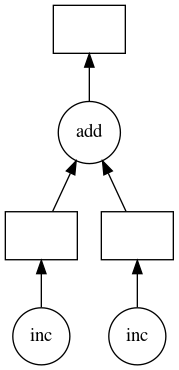

In [25]:
import dask.delayed as delayed
from dask.diagnostics import ProgressBar

def inc(i):
    return i + 1

def add(x, y):
    return x + y

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

z.visualize()

In [27]:
z.compute()

5

#### Listing 2.8. Performing the addTwo operation

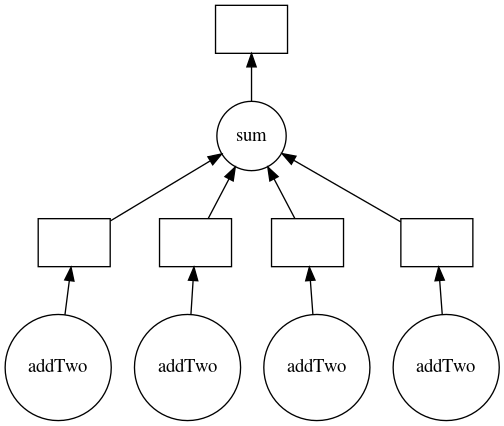

In [39]:
def addTwo(x):
    return x + 2

def sumTwoNumbers(x,y):
    return x + y

def multiplyFour(x):
    return x * 4

data = [1, 5, 8, 10]
# data = range(100)

step1 = [delayed(addTwo)(i) for i in data]
total = delayed(sum)(step1)
total.visualize()

In [40]:
total.compute()

32

#### Listing 2.9. Multiply each value by four

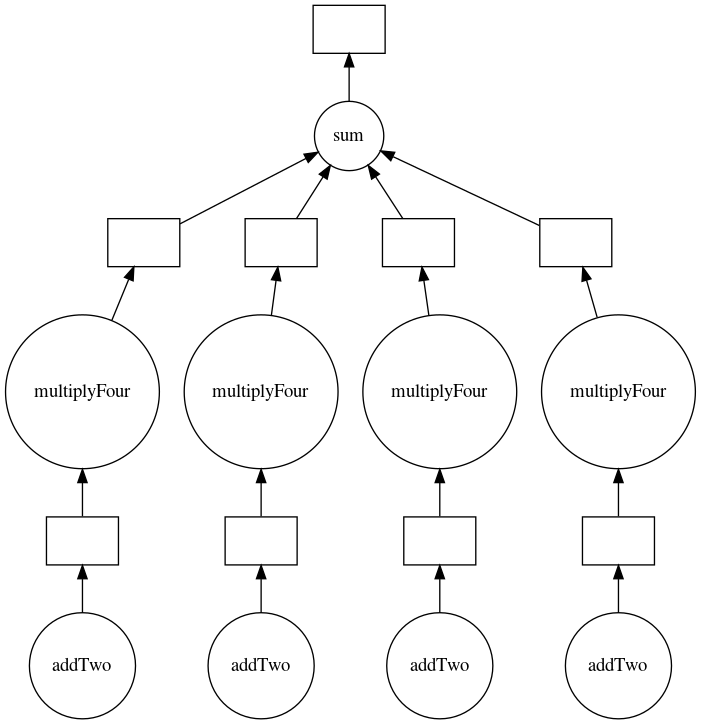

In [41]:
step1 = [delayed(addTwo)(i) for i in data]
step2 = [delayed(multiplyFour)(j) for j in step1]
total = delayed(sum)(step2)
total.visualize()

In [42]:
total.compute()

128

#### Listing 2.10. Adding another layer to the DAG

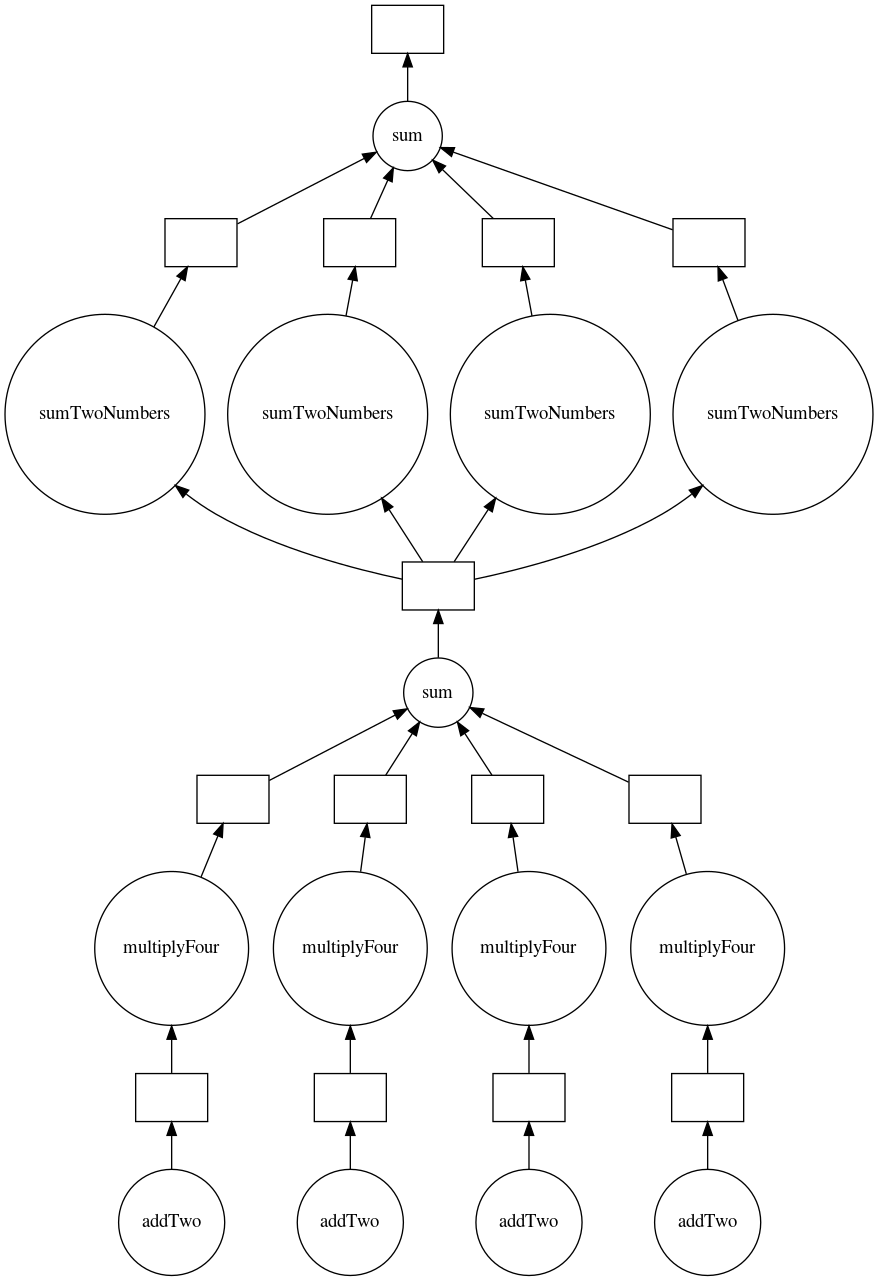

In [43]:
data2 = [delayed(sumTwoNumbers)(k, total) for k in data]
total2 = delayed(sum)(data2)
total2.visualize()

In [44]:
total2.compute()

536

#### Listing 2.11. Persisting calculations

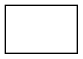

In [45]:
totalPersisted = total.persist()
totalPersisted.visualize()

#### Listing 2.12. Chaining a DAG from a persisted DAG

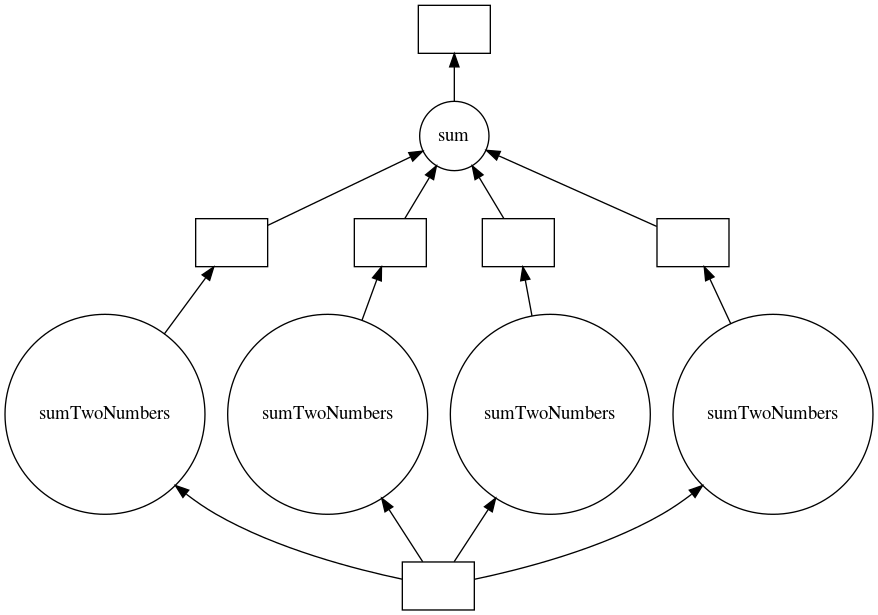

In [46]:
data2 = [delayed(sumTwoNumbers)(l, totalPersisted) for l in data]
total2 = delayed(sum)(data2)
total2.visualize()

In [47]:
total2.compute()

536

#### Listing 2.13. Visualizing the last NYC data DAG

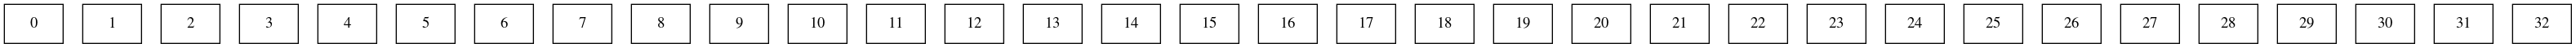

In [55]:
df_dropped.visualize()

## Chapter 3

### 3.1   Why Use DataFrames?

### 3.2   Dask and Pandas

#### Listing 3.2. Creating a DataFrame with a specific number of partitions

In [69]:
import pandas
import dask.dataframe as daskDataFrame

# A
personIDs = [1,2,3,4,5,6,7,8,9,10]
personLastNames = ['Smith', 'Williams', 'Williams','Jackson','Johnson','Smith','Anderson','Christiansen','Carter','Davidson']
personFirstName = ['John', 'Bill', 'Jane','Cathy','Stuart','James','Felicity','Liam','Nancy','Christina']
personDOBs = ['10/6/82', '7/4/90', '5/6/89','1/24/74','6/5/95','4/16/84','9/15/76','10/2/92','2/5/86','8/11/93']

# B
peoplePandasDataFrame = pandas.DataFrame({'Person ID':personIDs,
                                          'Last Name': personLastNames,
                                          'First Name': personFirstName,
                                          'Date of Birth': personDOBs},
                                         columns=['Person ID', 'Last Name', 'First Name', 'Date of Birth'])

peopleDaskDataFrame = daskDataFrame.from_pandas(peoplePandasDataFrame, npartitions=2)

In [63]:
peoplePandasDataFrame

,Person ID,Last Name,First Name,Date of Birth
0,1,Smith,John,10/6/82
1,2,Williams,Bill,7/4/90
2,3,Williams,Jane,5/6/89
3,4,Jackson,Cathy,1/24/74
4,5,Johnson,Stuart,6/5/95
5,6,Smith,James,4/16/84
6,7,Anderson,Felicity,9/15/76
7,8,Christiansen,Liam,10/2/92
8,9,Carter,Nancy,2/5/86
9,10,Davidson,Christina,8/11/93


#### Listing 3.3. Inspecting partitioning of a Dask DataFrame

In [70]:
peopleDaskDataFrame.divisions

(0, 5, 9)

In [71]:
peopleDaskDataFrame.npartitions

2

#### Listing 3.4. Inspecting the rows in a DataFrame

In [75]:
peopleDaskDataFrame.map_partitions(len).compute()

0    5
1    5
dtype: int64

#### Listing 3.5. Repartitioning a DataFrame

In [77]:
people_filtered = peopleDaskDataFrame[peopleDaskDataFrame ['Last Name'] != 'Williams']
people_filtered.map_partitions(len).compute()

0    3
1    5
dtype: int64

In [78]:
people_filtered_reduced = people_filtered.repartition(npartitions=1)
people_filtered_reduced.map_partitions(len).compute()

0    8
dtype: int64

Finally, if you have to use an operation that triggers a shuffle, persist the result if you have the resources to do so. This will prevent having to repeat shuffling the data again if the DataFrame needs to be recomputed.

### 3.3   Limitations of Dask DataFrames

For example, functions that would alter the structure of the DataFrame, such as insert and pop, are not supported because Dask DataFrames are immutable. Some of the more complex window operations are also not supported, such as expanding and ewm methods, as well as complex transposition methods like stack/unstack and melt, because of their tendency to cause a lot of data shuffling.

## Chapter 4